# Исследование объявлений о продаже квартир

В нашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма.

## Содержание<a name="Содержание"></a>

0. [Импорт библиотек](#0.-Импорт-библиотек)
1. [Знакомство с данными](#1.-Знакомство-с-данными)
	1. [Вывод](#Вывод)
2. [Предобработка данных](#2.-Предобработка-данных)
	1. [Обработка пропусков](#Обработка-пропусков)
	2. [Замена типа данных](#Замена-типа-данных)
	3. [Обработка дубликатов](#Обработка-дубликатов)
	4. [Вывод](#Вывод)
3. [Обогащение данных](#3.-Обогащение-данных)
	1. [Расчет цены квадратного метра](#Расчет-цены-квадратного-метра)
	2. [Расчет дня недели, месяца и года публикации](#Расчет-дня-недели,-месяца-и-года-публикации)
	3. [Категоризация по этажу](#Категоризация-по-этажу)
	4. [Расчет соотношения жилой и кухонной площадей к общей](#Расчет-соотношения-жилой-и-кухонной-площадей-к-общей)
	5. [Вывод](#Вывод)
4. [Исследовательский анализ данных](#4.-Исследовательский-анализ-данных)
	1. [Изучение площадей, цен, количества комнат и высоты потолков в квартирах](#Изучение-площадей,-цен,-количества-комнат-и-высоты-потолков-в-квартирах)
	2. [За какой срок продают квартиры](#За-какой-срок-продают-квартиры)
	3. [Избавление от редких и выбивающихся значений](#Избавление-от-редких-и-выбивающихся-значений)
	4. [Факторы, влияющие на стоимость квартиры](#Факторы,-влияющие-на-стоимость-квартиры)
	5. [Исследование 10 населённых пунктов с наибольшим числом объявлений](#Исследование-10-населённых-пунктов-с-наибольшим-числом-объявлений)
	6. [Определение центральной зоны Санкт-Петербурга](#Определение-центральной-зоны-Санкт-Петербурга)
	7. [Сравнение квартир в центре Санкт-Петербурга с остальным городом](#Сравнение-квартир-в-центре-Санкт-Петербурга-с-остальным-городом)
5. [Общий вывод](#5.-Общий-вывод)

## 0. Импорт библиотек<a name="0.-Импорт-библиотек"></a>

Перед началом работы импортируем библиотеки:
- `pandas` — для работы с таблицами,
- `matplotlib` — для построения графиков.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

## 1. Знакомство с данными<a name="1.-Знакомство-с-данными"></a>

Сохраним датафрейм в переменную `df` и посмотрим на общую информацию.

In [2]:
df = pd.read_csv('real_estate_data.csv', sep='\t' , decimal=',')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   total_images          23699 non-null  int64 
 1   last_price            23699 non-null  object
 2   total_area            23699 non-null  object
 3   first_day_exposition  23699 non-null  object
 4   rooms                 23699 non-null  int64 
 5   ceiling_height        14504 non-null  object
 6   floors_total          23613 non-null  object
 7   living_area           21796 non-null  object
 8   floor                 23699 non-null  int64 
 9   is_apartment          2775 non-null   object
 10  studio                23699 non-null  bool  
 11  open_plan             23699 non-null  bool  
 12  kitchen_area          21421 non-null  object
 13  balcony               12180 non-null  object
 14  locality_name         23650 non-null  object
 15  airports_nearest      18157 non-null

Рассмотрим полученные данные. В таблице 22 столбца трех разных типов: `int64`, `object` и `bool`. Вот какую информацию содержит каждый столбец:

* *airports_nearest* — расстояние до ближайшего аэропорта в метрах (м)
* *balcony* — число балконов
* *ceiling_height* — высота потолков (м)
* *cityCenters_nearest* — расстояние до центра города (м)
* *days_exposition* — сколько дней было размещено объявление (от публикации до снятия)
* *first_day_exposition* — дата публикации
* *floor* — этаж
* *floors_total* — всего этажей в доме
* *is_apartment* — апартаменты (булев тип)
* *kitchen_area* — площадь кухни в квадратных метрах (м²)
* *last_price* — цена на момент снятия с публикации
* *living_area* — жилая площадь в квадратных метрах(м²)
* *locality_name* — название населённого пункта
* *open_plan* — свободная планировка (булев тип)
* *parks_around3000* — число парков в радиусе 3 км
* *parks_nearest* — расстояние до ближайшего парка (м)
* *ponds_around3000* — число водоёмов в радиусе 3 км
* *ponds_nearest* — расстояние до ближайшего водоёма (м)
* *rooms* — число комнат
* *studio* — квартира-студия (булев тип)
* *total_area* — площадь квартиры в квадратных метрах (м²)
* *total_images* — число фотографий квартиры в объявлении

Посмотрим на данные поближе.

In [3]:
df.head(10)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.7,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0
5,10,2890000.0,30.4,2018-09-10T00:00:00,1,NaN,12.0,14.4,5,NaN,...,9.1,NaN,городской посёлок Янино-1,NaN,NaN,NaN,NaN,NaN,NaN,55.0
6,6,3700000.0,37.3,2017-11-02T00:00:00,1,NaN,26.0,10.6,6,NaN,...,14.4,1.0,посёлок Парголово,52996.0,19143.0,0.0,NaN,0.0,NaN,155.0
7,5,7915000.0,71.6,2019-04-18T00:00:00,2,NaN,24.0,NaN,22,NaN,...,18.9,2.0,Санкт-Петербург,23982.0,11634.0,0.0,NaN,0.0,NaN,NaN
8,20,2900000.0,33.16,2018-05-23T00:00:00,1,NaN,27.0,15.43,26,NaN,...,8.81,NaN,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,189.00000000000003
9,18,5400000.0,61.0,2017-02-26T00:00:00,3,2.5,9.0,43.6,7,NaN,...,6.5,2.0,Санкт-Петербург,50898.0,15008.0,0.0,NaN,0.0,NaN,289.0


Столбцов очень много, поэтому `pandas` выводит не все. *Прикажем* ему показывать больше и попробую вывести данные еще раз.

In [4]:
pd.set_option('display.max_columns', None)
df.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.7,16.0,51.0,8,NaN,False,False,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,False,False,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,False,False,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,False,False,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,False,False,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


### Вывод

Из общей информации видно, что значения в столбцах `last_price`, `total_area`, `first_day_exposition`, `ceiling_height`, `floors_total`, `living_area`, `is_apartment`, `kitchen_area`, `balcony`, `airports_nearest`, `cityCenters_nearest`, `parks_around3000`, `parks_nearest`, `ponds_around3000`, `ponds_nearest`, `days_exposition` имеют тип `object`. При этом по логике эти столбцы должны быть `float`, `int`, `bool` или `datetime`. Нестрашно: приведем данные к нужным типам.

Также в некоторых столбцах есть пропуски. Мы будем обрабатывать не все, а только те, которые пригодятся для нашего исследования. А именно: `floors_total`, `living_area`, `kitchen_area`, `ceiling_height`, `days_exposition`, `cityCenters_nearest`. Пропуски есть еще и в столбце `locality_name`, который тоже нужен для нашего исследования, но мы не можем их заполнить.

[К содержанию](#Содержание)

## 2. Предобработка данных<a name="2.-Предобработка-данных"></a>

Перед предобработкой данных надо разобраться с тем, что почти все данные в датафрейме имеют неправильный тип `object`. Распределим столбцы с неправильными типами по правильным:

* **int**: last_price, floors_total, balcony, airports_nearest, cityCenters_nearest, parks_around3000, parks_nearest, ponds_around3000, ponds_nearest, days_exposition

* **float**: total_area, ceiling_height, living_area, kitchen_area

* **bool**: is_apartament

* **datetime**: first_day_exposition

Но до обработки пропусков дадим целочисленным переменным тип `float` — так с ними будет проще работать. `int`, например, не поддерживает NaN'ы, потому что это они имеют тип `float`. Сразу проверим, что получилось.

In [5]:
type_dict = {'last_price': 'float',
             'floors_total': 'float',
             'balcony': 'float',
             'airports_nearest': 'float',
             'cityCenters_nearest': 'float',
             'parks_around3000': 'float',
             'parks_nearest': 'float',
             'ponds_around3000': 'float',
             'ponds_nearest': 'float',
             'days_exposition': 'float',
             'total_area': 'float',
             'ceiling_height': 'float',
             'living_area': 'float',
             'kitchen_area': 'float',
             'is_apartment': 'bool'
            }
df = df.astype(type_dict, errors = 'ignore')
df['first_day_exposition']= pd.to_datetime(df['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')
df.dtypes

total_images                     int64
last_price                     float64
total_area                     float64
first_day_exposition    datetime64[ns]
rooms                            int64
ceiling_height                 float64
floors_total                   float64
living_area                    float64
floor                            int64
is_apartment                      bool
studio                            bool
open_plan                         bool
kitchen_area                   float64
balcony                        float64
locality_name                   object
airports_nearest               float64
cityCenters_nearest            float64
parks_around3000               float64
parks_nearest                  float64
ponds_around3000               float64
ponds_nearest                  float64
days_exposition                float64
dtype: object

### Обработка пропусков<a name="Обработка-пропусков"></a>

Вспомним столбцы, пропуски в которых нам интересны: `floors_total`, `living_area`, `kitchen_area`, `ceiling_height`, `days_exposition`, `locality_name`, `cityCenters_nearest`.

**Из-за чего могли появиться пропуски?**
* Значения в столбцах `floors_total`, `living_area`, `kitchen_area`, `ceiling_height` и `locality_name`, скорее всего, не заполнили сами продавцы. При этом вряд ли эти пропуски были умышленными. Думаю, они появились из-за невнимательности. Поэтому отнесем их к полностью случайным.
* Пропуски в `cityCenters_nearest` похожи на технический сбой. Возможно, невсегда запускается механизм, который автоматически рассчитывает значение при добавлении новой квартиры в базу данных. Тоже отнесем их к полностью случайным.
* `days_exposition` может пустовать, потому что на момент выгрузки данных квартира была не продана. Оставим эти значения не заполненными.

В столбце `total_area` пропусков нет, значит, мы можем заполнить пропуски в `living_area` и `kitchen_area` значениями пропорциональными общей площади квартиры. Для этого рассчитаем коэффициенты отношения жилой и кухонной площади к общей. В расчетах будем использовать средние значения соответствующих столбцов.

In [6]:
living_to_total = df['living_area'].mean() / df['total_area'].mean()
kitchen_to_total = df['kitchen_area'].mean() / df['total_area'].mean()

df['living_area'] = df['living_area'].fillna(df['total_area'] * living_to_total)
df['kitchen_area'] = df['kitchen_area'].fillna(df['total_area'] * kitchen_to_total)

Проверим, что пропусков в столбцах `living_area` и `kitchen_area` больше нет:

In [7]:
print(df['living_area'].isnull().sum())
print(df['kitchen_area'].isnull().sum())

0
0


Столбцы `floors_total`, `ceiling_height` и `cityCenters_nearest` заполним медианами этих значений по населенным пунктам. То есть будем считать, что дома в каждом населенном пункте похожи друг на друга. Если после такого заполнения пропуски все равно останутся, не будем это исправлять. Если заполнить их медианой по столбцу, то они сильно исказят распределения.

In [8]:
df['floors_total'] = df['floors_total'].fillna(
                        df.groupby('locality_name')['floors_total'].transform('median'))

df['ceiling_height'] = df['ceiling_height'].fillna(
                        df.groupby('locality_name')['ceiling_height'].transform('median'))

df['cityCenters_nearest'] = df['cityCenters_nearest'].fillna(
                        df.groupby('locality_name')['cityCenters_nearest'].transform('median'))

In [9]:
df['floors_total'] = (df['floors_total'].fillna(
    df.groupby('locality_name')['floors_total'].transform('median')))

### Замена типа данных<a name="Замена-типа-данных"></a>

Неправильные типы данных могли появиться во время выгрузки данных или из-за ее настроек. Здесь возможны и технический, и человеческий факторы.

Вспомним наше распределение по правильным типам:

* **int**: last_price, floors_total, balcony, airports_nearest, cityCenters_nearest, parks_around3000, parks_nearest, ponds_around3000, ponds_nearest, days_exposition

* **float**: total_area, ceiling_height, living_area, kitchen_area

* **bool**: is_apartament

* **datetime**: first_day_exposition

У нас остались столбцы, в которых есть пропуски, но которые должны иметь целочисленные значения. При этом `int` не поддерживает NaN'ы, потому что в python это значение имеет тип `float`. Поэтому вместо `int` будем использовать в них `Int`, который является расширением `int` с поддержкой NaN'ов.

In [10]:
new_type_dict = {
             'total_images': 'uint8',
             'last_price': 'uint32',
             'total_area': 'float16',
             'rooms': 'uint8',
             'ceiling_height': 'float16',
             'floors_total': 'Int8',
             'living_area': 'float16',
             'floor': 'uint8',
             'is_apartment': 'bool',
             'kitchen_area': 'float16',
             'balcony': 'Int8',
             'airports_nearest': 'Int32',
             'cityCenters_nearest': 'Int32',
             'parks_around3000': 'Int8',
             'parks_nearest': 'Int16',
             'ponds_around3000': 'Int8',
             'ponds_nearest': 'Int16',
             'days_exposition': 'Int16',
             }

df = df.astype(new_type_dict, errors = 'ignore')
df.dtypes

total_images                     uint8
last_price                      uint32
total_area                     float16
first_day_exposition    datetime64[ns]
rooms                            uint8
ceiling_height                 float16
floors_total                   float64
living_area                    float16
floor                            uint8
is_apartment                      bool
studio                            bool
open_plan                         bool
kitchen_area                   float16
balcony                           Int8
locality_name                   object
airports_nearest                 Int32
cityCenters_nearest            float64
parks_around3000                  Int8
parks_nearest                    Int16
ponds_around3000                  Int8
ponds_nearest                    Int16
days_exposition                float64
dtype: object

У столбца `days_exposition` почему-то не поменялся тип. Возможно, из-за странных дробных частей:

In [11]:
sorted(df['cityCenters_nearest'].unique())

[208.0,
 287.0,
 318.0,
 399.0,
 436.0,
 467.0,
 472.0,
 515.0,
 573.0,
 594.0,
 602.0,
 650.0,
 653.0,
 658.0,
 671.0,
 686.0,
 700.0,
 730.0,
 743.0,
 801.0,
 814.0,
 820.0,
 830.0,
 835.0,
 853.0,
 936.0,
 945.0,
 964.0,
 996.0,
 1053.0,
 1075.0,
 1090.0,
 1097.0,
 1141.0,
 1152.0,
 1155.0,
 1178.0,
 1181.0,
 1197.0,
 1200.0,
 1211.0,
 1240.0,
 1249.0,
 1253.0,
 1261.0,
 1276.0,
 1280.0,
 1281.0,
 1283.0,
 1292.0,
 1295.0,
 1298.0,
 1313.0,
 1325.0,
 1356.0,
 1369.0,
 1376.0,
 1381.0,
 1404.0,
 1424.0,
 1431.0,
 1454.0,
 1492.0,
 1509.0,
 1514.0,
 1572.0,
 1589.0,
 1592.0,
 1637.0,
 1641.0,
 1722.0,
 1724.0,
 1725.0,
 1754.0,
 1755.0,
 1772.0,
 1780.0,
 1796.0,
 1826.0,
 1847.0,
 1848.0,
 1852.0,
 1862.0,
 1884.0,
 1898.0,
 1899.0,
 1900.0,
 1902.0,
 1921.0,
 1936.0,
 1949.0,
 1963.0,
 2009.0,
 2012.0,
 2021.0,
 2056.0,
 2067.0,
 2130.0,
 2136.0,
 2139.0,
 2142.0,
 2143.0,
 2144.0,
 2164.0,
 2169.0,
 2180.0,
 2184.0,
 2211.0,
 2229.0,
 2242.0,
 2245.0,
 2254.0,
 2256.0,
 2267.0,
 22

Округлим значения функцией `round()` и попробуем еще раз.

In [12]:
df['days_exposition'] = round(df['days_exposition'])
df['days_exposition'] = df['days_exposition'].astype('Int16')
df.dtypes['days_exposition']

Int16Dtype()

### Обработка дубликатов<a name="Обработка-дубликатов"></a>

Перед тем как искать дубликаты, обработаем столбец `locality_name`: в нем могут быть скрытые дубли из-за несистематизированного ввода. 

In [13]:
df['locality_name'] = df['locality_name'].fillna('')
unique_locality_names = df['locality_name'].unique().tolist()
unique_locality_names.sort()
unique_locality_names

['',
 'Бокситогорск',
 'Волосово',
 'Волхов',
 'Всеволожск',
 'Выборг',
 'Высоцк',
 'Гатчина',
 'Зеленогорск',
 'Ивангород',
 'Каменногорск',
 'Кингисепп',
 'Кириши',
 'Кировск',
 'Колпино',
 'Коммунар',
 'Красное Село',
 'Кронштадт',
 'Кудрово',
 'Лодейное Поле',
 'Ломоносов',
 'Луга',
 'Любань',
 'Мурино',
 'Никольское',
 'Новая Ладога',
 'Отрадное',
 'Павловск',
 'Петергоф',
 'Пикалёво',
 'Подпорожье',
 'Приморск',
 'Приозерск',
 'Пушкин',
 'Санкт-Петербург',
 'Светогорск',
 'Сертолово',
 'Сестрорецк',
 'Сланцы',
 'Сосновый Бор',
 'Сясьстрой',
 'Тихвин',
 'Тосно',
 'Шлиссельбург',
 'городской поселок Большая Ижора',
 'городской поселок Янино-1',
 'городской посёлок Будогощь',
 'городской посёлок Виллози',
 'городской посёлок Лесогорский',
 'городской посёлок Мга',
 'городской посёлок Назия',
 'городской посёлок Новоселье',
 'городской посёлок Павлово',
 'городской посёлок Рощино',
 'городской посёлок Свирьстрой',
 'городской посёлок Советский',
 'городской посёлок Фёдоровское',
 'го

Мы посмотрели на уникальные значения столбца и заметили, что некоторые населенные пункты с буквой «ё» в название записаны разными способами: через «е» и через «ё». Также мы увидели закономерность, что имя собственное начинается с первой заглавной буквы в ячейке и идет до конца строки.

Напишем функцию `fix_locality_name`, исправляющую значения в столбце `locality_name`. Она будет отсекать все символы до первой заглавной буквы в названии и менять букву «ё» на «е».

In [14]:
def fix_locality_name(locality_name):
    first_uppercase_symbol_index = 0
    uppercase_found = False
    fixed_locality_name = ''
    
    for i in range(len(locality_name)):
        if (locality_name[i].isupper()) & (uppercase_found == False):
            first_uppercase_symbol_index = i
            uppercase_found = True
    locality_name = locality_name[first_uppercase_symbol_index:]
    
    for symbol in locality_name:
        if symbol == 'ё':
            fixed_locality_name += 'е'
        elif symbol == 'Ё':
            fixed_locality_name += 'Е'    
        else:
            fixed_locality_name += symbol
    return fixed_locality_name
    
df['locality_name'] = df['locality_name'].apply(fix_locality_name)

Проверим, что функция сработала правильно:

In [15]:
unique_locality_names = df['locality_name'].unique().tolist()
unique_locality_names.sort()
unique_locality_names

['',
 'Агалатово',
 'Александровская',
 'Алексеевка',
 'Аннино',
 'Аро',
 'Барышево',
 'Батово',
 'Бегуницы',
 'Белогорка',
 'Белоостров',
 'Бокситогорск',
 'Большая Вруда',
 'Большая Ижора',
 'Большая Пустомержа',
 'Большие Колпаны',
 'Большое Рейзино',
 'Большой Сабск',
 'Бор',
 'Борисова Грива',
 'Бугры',
 'Будогощь',
 'Ваганово',
 'Важины',
 'Вартемяги',
 'Вахнова Кара',
 'Вещево',
 'Виллози',
 'Вознесенье',
 'Возрождение',
 'Войсковицы',
 'Войскорово',
 'Володарское',
 'Волосово',
 'Волхов',
 'Всеволожск',
 'Выборг',
 'Вырица',
 'Выскатка',
 'Высокоключевой',
 'Высоцк',
 'Гаврилово',
 'Гарболово',
 'Гатчина',
 'Гладкое',
 'Глажево',
 'Глебычево',
 'Глинка',
 'Гончарово',
 'Горбунки',
 'Гостилицы',
 'Громово',
 'Дзержинского',
 'Дружная Горка',
 'Дружноселье',
 'Дубровка',
 'Елизаветино',
 'Ефимовский',
 'Жилгородок',
 'Жилпоселок',
 'Житково',
 'Заводской',
 'Заклинье',
 'Заневка',
 'Запорожское',
 'Зеленогорск',
 'Зимитицы',
 'Ивангород',
 'Извара',
 'Ильичево',
 'Иссад',
 'Калит

С помощью метода `duplicated()` проверим, есть ли в датафрейме дубликаты:

In [16]:
df.duplicated().sum()

0

Дубликатов нет — ура!

### Вывод

Мы подготовили данные к исследованию: заполнили некоторые пропуски в нужных нам столбцах, привели значения к подходящим типам, проверили отсутствие дубликатов.

[К содержанию](#Содержание)

## 3. Обогащение данных<a name="3.-Обогащение-данных"></a>

### Расчет цены квадратного метра<a name="Расчет-цены-квадратного-метра"></a>

Чтобы получить цену квадратного метра, надо разделить стоимость квартиры на ее площадь. Сделаем это, округлим результат до целых и добавим результат в новый столбец `price_per_meter`.

In [17]:
df['price_per_meter'] = round(df['last_price'] / df['total_area']).astype('int')

Проверим, что столбец добавился.

In [18]:
df.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_per_meter
0,20,13000000,108.00000,2019-03-07,3,2.699219,16.0,51.00000,8,True,False,False,25.000000,<NA>,Санкт-Петербург,18863,16028.0,1,482,2,755,<NA>,120370
1,7,3350000,40.40625,2018-12-04,1,2.630859,11.0,18.59375,1,True,False,False,11.000000,2,Шушары,12817,18603.0,0,<NA>,0,<NA>,81,82908
2,10,5196000,56.00000,2015-08-20,2,2.699219,5.0,34.31250,4,True,False,False,8.296875,0,Санкт-Петербург,21741,13933.0,1,90,2,574,558,92786
3,0,64900000,159.00000,2015-07-24,3,2.699219,14.0,90.81250,9,True,False,False,27.843750,0,Санкт-Петербург,28098,6800.0,2,84,3,234,424,408176
4,2,10000000,100.00000,2018-06-19,2,3.029297,14.0,32.00000,13,True,False,False,41.000000,<NA>,Санкт-Петербург,31856,8098.0,2,112,1,48,121,100000


### Расчет дня недели, месяца и года публикации<a name="Расчет-дня-недели,-месяца-и-года-публикации"></a>

День недели можно получить, применив к столбцу с датой публикации метод `day_name`. Сделаем это и запишем результат в новый столбец `day_of_week_exposition`.

In [19]:
df['day_of_week_exposition'] = df['first_day_exposition'].dt.day_name()

Чтобы получить месяц и год, надо сделать почти то же самое. Для месяца вместо метода `day_name()` будет `month_name()`, а для года — свойство `year`. Сохраним новые значения в столбцы `month_exposition` и `year_exposition`.

In [20]:
df['month_exposition'] = df['first_day_exposition'].dt.month_name()
df['year_exposition'] = df['first_day_exposition'].dt.year

In [21]:
df.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_per_meter,day_of_week_exposition,month_exposition,year_exposition
0,20,13000000,108.00000,2019-03-07,3,2.699219,16.0,51.00000,8,True,False,False,25.000000,<NA>,Санкт-Петербург,18863,16028.0,1,482,2,755,<NA>,120370,Thursday,March,2019
1,7,3350000,40.40625,2018-12-04,1,2.630859,11.0,18.59375,1,True,False,False,11.000000,2,Шушары,12817,18603.0,0,<NA>,0,<NA>,81,82908,Tuesday,December,2018
2,10,5196000,56.00000,2015-08-20,2,2.699219,5.0,34.31250,4,True,False,False,8.296875,0,Санкт-Петербург,21741,13933.0,1,90,2,574,558,92786,Thursday,August,2015
3,0,64900000,159.00000,2015-07-24,3,2.699219,14.0,90.81250,9,True,False,False,27.843750,0,Санкт-Петербург,28098,6800.0,2,84,3,234,424,408176,Friday,July,2015
4,2,10000000,100.00000,2018-06-19,2,3.029297,14.0,32.00000,13,True,False,False,41.000000,<NA>,Санкт-Петербург,31856,8098.0,2,112,1,48,121,100000,Tuesday,June,2018


### Категоризация по этажу<a name="Категоризация-по-этажу"></a>

Напишем функцию, которая определяет, на каком этаже — первом, последнем или другом — находится квартира. После этого с помощью метода `apply()` применим ее к датафрейму и сохраним результат в новый столбец `floor_category`.

In [22]:
def set_floor_category(row):
    floor = row['floor']
    floors_total = row['floors_total']
    if floor == 1:
        return 'первый'
    elif floor == floors_total:
        return 'последний'
    return 'прочий (не первый и не последний)'

df['floor_category'] = df.apply(set_floor_category, axis=1)

Проверим, все ли сработало и как.

In [23]:
df.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_per_meter,day_of_week_exposition,month_exposition,year_exposition,floor_category
0,20,13000000,108.00000,2019-03-07,3,2.699219,16.0,51.00000,8,True,False,False,25.000000,<NA>,Санкт-Петербург,18863,16028.0,1,482,2,755,<NA>,120370,Thursday,March,2019,прочий (не первый и не последний)
1,7,3350000,40.40625,2018-12-04,1,2.630859,11.0,18.59375,1,True,False,False,11.000000,2,Шушары,12817,18603.0,0,<NA>,0,<NA>,81,82908,Tuesday,December,2018,первый
2,10,5196000,56.00000,2015-08-20,2,2.699219,5.0,34.31250,4,True,False,False,8.296875,0,Санкт-Петербург,21741,13933.0,1,90,2,574,558,92786,Thursday,August,2015,прочий (не первый и не последний)
3,0,64900000,159.00000,2015-07-24,3,2.699219,14.0,90.81250,9,True,False,False,27.843750,0,Санкт-Петербург,28098,6800.0,2,84,3,234,424,408176,Friday,July,2015,прочий (не первый и не последний)
4,2,10000000,100.00000,2018-06-19,2,3.029297,14.0,32.00000,13,True,False,False,41.000000,<NA>,Санкт-Петербург,31856,8098.0,2,112,1,48,121,100000,Tuesday,June,2018,прочий (не первый и не последний)


Все получилось! Столбцы на месте, значения в них правильные.

### Расчет соотношения жилой и кухонной площадей к общей<a name="Расчет-соотношения-жилой-и-кухонной-площадей-к-общей"></a>

Для того чтобы получить искомые значения, поделим столбцы `living_area` и `kitchen_area` на `total_area`. Сохраним новые значения в столбцы `living_to_total_area_ratio` и `kitchen_to_total_area_ratio` соответственно. Сразу же проверим, что получилось.

In [24]:
df['living_to_total_area_ratio'] = df['living_area'] / df['total_area']
df['kitchen_to_total_area_ratio'] = df['kitchen_area'] / df['total_area']
df.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_per_meter,day_of_week_exposition,month_exposition,year_exposition,floor_category,living_to_total_area_ratio,kitchen_to_total_area_ratio
0,20,13000000,108.00000,2019-03-07,3,2.699219,16.0,51.00000,8,True,False,False,25.000000,<NA>,Санкт-Петербург,18863,16028.0,1,482,2,755,<NA>,120370,Thursday,March,2019,прочий (не первый и не последний),0.472168,0.231445
1,7,3350000,40.40625,2018-12-04,1,2.630859,11.0,18.59375,1,True,False,False,11.000000,2,Шушары,12817,18603.0,0,<NA>,0,<NA>,81,82908,Tuesday,December,2018,первый,0.460205,0.272217
2,10,5196000,56.00000,2015-08-20,2,2.699219,5.0,34.31250,4,True,False,False,8.296875,0,Санкт-Петербург,21741,13933.0,1,90,2,574,558,92786,Thursday,August,2015,прочий (не первый и не последний),0.612793,0.148193
3,0,64900000,159.00000,2015-07-24,3,2.699219,14.0,90.81250,9,True,False,False,27.843750,0,Санкт-Петербург,28098,6800.0,2,84,3,234,424,408176,Friday,July,2015,прочий (не первый и не последний),0.571289,0.175171
4,2,10000000,100.00000,2018-06-19,2,3.029297,14.0,32.00000,13,True,False,False,41.000000,<NA>,Санкт-Петербург,31856,8098.0,2,112,1,48,121,100000,Tuesday,June,2018,прочий (не первый и не последний),0.320068,0.409912


### Вывод

Мы рассчитали и добавили в датафрейм новые значения, которые пригодятся нам в исследовательском анализе:
- в столбце `price_per_meter` хранится цена за квадратный метр квартиры;
- в `day_of_week_exposition`, `month_exposition`, `year_exposition` — день, месяц и год публикации объявления соответственно;
- столбец `floor_category` содержит название категории, к которой относится квартира в зависимости от того, на каком этаже она находится: первом, последнем или другом;
- в столбцах `living_to_total_area_ratio` и `kitchen_to_total_area_ratio` записаны отношение жилой и кухонной площади к общей.

[К содержанию](#Содержание)

## 4. Исследовательский анализ данных<a name="4.-Исследовательский-анализ-данных"></a>

### Изучение площадей, цен, количества комнат и высоты потолков в квартирах<a name="Изучение-площадей,-цен,-количества-комнат-и-высоты-потолков-в-квартирах"></a>

Начнем анализ с исследования следуюших параметров: площадь, цена, число комнат, высота потолков. 

In [25]:
exploration_columns = ['total_area', 'last_price', 'rooms', 'ceiling_height']
df[exploration_columns].describe()

,total_area,last_price,rooms,ceiling_height
count,23699.000,2.369900e+04,23699.000000,23543.000000
mean,inf,6.541549e+06,2.070636,2.732422
std,inf,1.088701e+07,1.078405,1.012695
min,12.000,1.219000e+04,0.000000,1.000000
25%,40.000,3.400000e+06,1.000000,2.550781
50%,52.000,4.650000e+06,2.000000,2.699219
75%,69.875,6.800000e+06,3.000000,2.699219
max,900.000,7.630000e+08,19.000000,100.000000


Смущают минимальные и максимальные значения во всех столбцах. Наверняка это выбросы, от которых придется избавляться. В столбцах `total_area` и `last_price` среднее гораздо больше медианы: на 15% и 40% соответственно.

Построим гистограммы для нужных столбцов и изучим их.

#### Распределение количества квартир по площадям

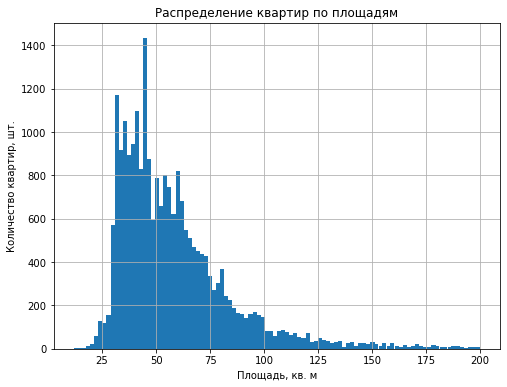

In [26]:
df.hist('total_area', bins=100, range=(12, 200), figsize=(8, 6))
plt.title('Распределение квартир по площадям')
plt.xlabel('Площадь, кв. м')
plt.ylabel('Количество квартир, шт.')
total_area_hist = plt.gcf()

Я специально поставил правую границу диапазона меньше максимального значения. Если оставить максимальное значение, гистограмма становится менее наглядной. Да и количество квартир с площадью больше 150 квадратных метров стремится к нулю.

Получившееся распредление не похоже ни на нормальное, ни на распределение Пуассона. Видно, что большинство квартир имеют площаль до 70 квадратных метров, а дальше идет резкое падение. Также выделяется пик в районе 45 квадратных меров.

#### Число квартир по ценам

Посмотрим на гистограмму, отображающую разброс цен.

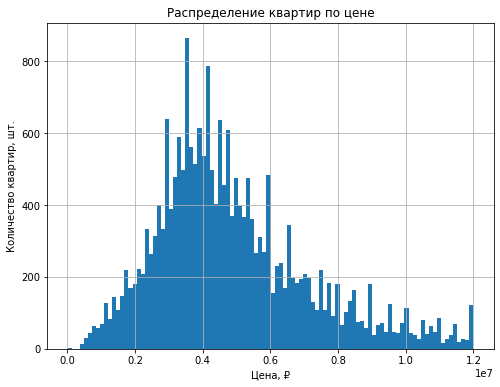

In [27]:
df.hist('last_price', bins=100, range=(12000, 12000000), figsize=(8, 6))
plt.title('Распределение квартир по цене')
plt.xlabel('Цена, ₽')
plt.ylabel('Количество квартир, шт.')
last_price_hist = plt.gcf()

Гистограмму можно было бы назвать нормальной, если бы не большое количество зубчиков-пиков. Больше всего квартир за 3,5–5,5 миллиона рублей.

#### Распределение числа квартир по количеству комнат

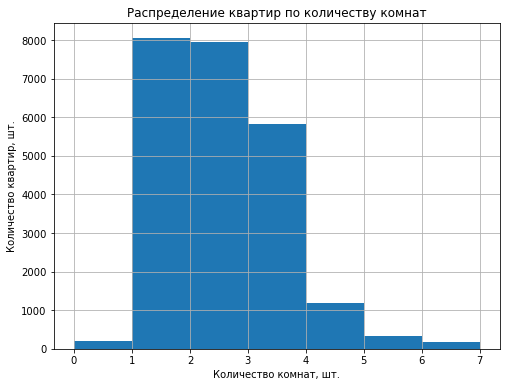

In [28]:
df.hist('rooms', bins=7, range=(0, 7), figsize=(8, 6))
plt.title('Распределение квартир по количеству комнат')
plt.xlabel('Количество комнат, шт.')
plt.ylabel('Количество квартир, шт.')
rooms_hist = plt.gcf()

Гистограмма с количеством комнат в квартирах получилась предсказуемой. Кроме нуля — но это выбросы, с которыми мы разберемся позже.

#### Квартиры по высоте потолков

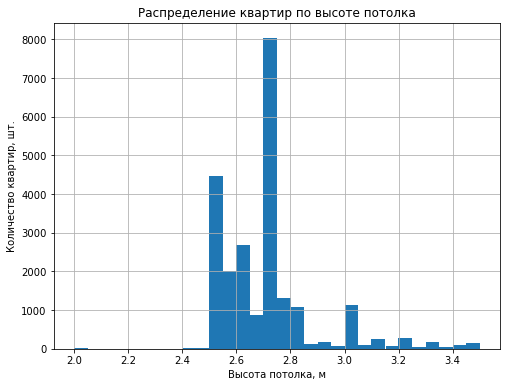

In [29]:
df.hist('ceiling_height', bins=30, range=(2, 3.5), figsize=(8, 6))
plt.title('Распределение квартир по высоте потолка')
plt.xlabel('Высота потолка, м')
plt.ylabel('Количество квартир, шт.')
ceiling_height_hist = plt.gcf()

Высокий потолок радует глаз — наверное, поэтому их так много. На втором месте, наоборот, низкие потолки. Думаю, два пика можно объяснить строительными стандартами с двумя разными высотами потолков.

### За какой срок продают квартиры<a name="За-какой-срок-продают-квартиры"></a>

Перед тем как обозначить быстрые и медленные продажи, посмотрим на общие инфорамцию о времени реализации квартир.

In [30]:
df['days_exposition'].describe()

count    20518.000000
mean       180.888634
std        219.727988
min          1.000000
25%         45.000000
50%         95.000000
75%        232.000000
max       1580.000000
Name: days_exposition, dtype: float64

Среднее время продажи квартир — 181 день, а медианное значение — 95. Значит квартиры чаще продают быстрее среднего времени.

Посмотрим на гистограмму.

Text(0, 0.5, 'Количество квартир, шт.')

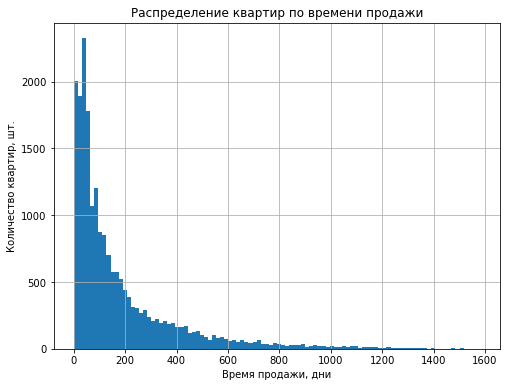

In [31]:
df.hist('days_exposition', bins=100, figsize=(8, 6))
plt.title('Распределение квартир по времени продажи')
plt.xlabel('Время продажи, дни')
plt.ylabel('Количество квартир, шт.')

Гистограмма похожа на распределение Пуассона, но по ней сложно понять, какой срок продажи считать коротким, а какой длинным. Видно, что продажи длиннее 500 дней — редкость, но точно ли это пограничное значение? Проверим с помощью диаграммы размаха.

(0.0, 700.0)

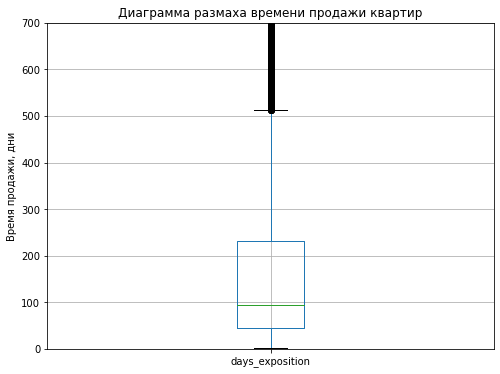

In [32]:
df.boxplot('days_exposition', figsize=(8, 6))
plt.title('Диаграмма размаха времени продажи квартир')
plt.ylabel('Время продажи, дни')
plt.ylim(0,700)

На диаграмме видно, что правый «ус» находится около 500 дней. Будем считать это значение пограничным и что продажи более 500 дней — долгие.

Левый «ус» упирается в ноль, поэтому с определеним быстрых продаж диаграмма нам не поможет. «Приблизим» гистограмму в районе начала.

Text(0, 0.5, 'Количество квартир, шт.')

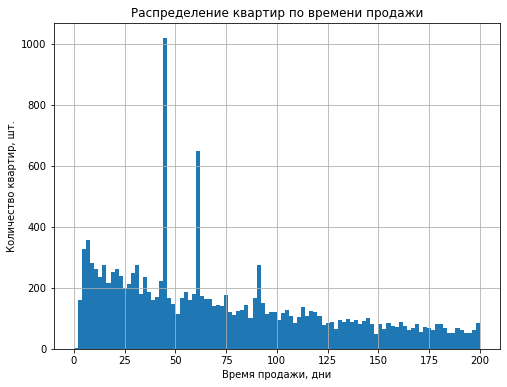

In [33]:
df.hist('days_exposition', bins=100, range=(0, 200), figsize=(8, 6))
plt.title('Распределение квартир по времени продажи')
plt.xlabel('Время продажи, дни')
plt.ylabel('Количество квартир, шт.')

Вылезли пики, но яснее не стало. Посмотрим на начало гистограммы еще ближе.

Text(0, 0.5, 'Количество квартир, шт.')

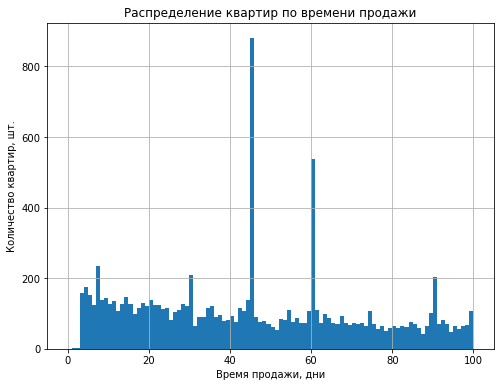

In [34]:
df.hist('days_exposition', bins=100, range=(0, 100), figsize=(8, 6))
plt.title('Распределение квартир по времени продажи')
plt.xlabel('Время продажи, дни')
plt.ylabel('Количество квартир, шт.')

Стало видно, что продаж за 1-3 дня почти нет. Такие и будем считать очень быстрыми.

Образовавшиеся пики на значениях 45, 60 и 90 дней можно объяснить тем, что в Яндекс.Недвижимости в эти периоды заканчивается срок бесплатного размещения объявлений. То есть это не настоящие продажи, а автоматические закрытия объявлений, которые так засчитались. К сожалению, мы не сможем избавиться от этих выбросов: непонятно, где реальные продажи, а где нет.

#### Вывод

С помощью гистограмм и диаграммы размаха мы изучили время продажи квартир и пришли к выводу, что продажи дольше 500 — слишком длинные, а быстрее 3 дня — аномально быстрые.

### Избавление от редких и выбивающихся значений<a name="Избавление-от-редких-и-выбивающихся-значений"></a>

В дальнейшем исследовании нам понадобятся следующие параметры: цена, площадь, число комнат, удаленность от центра, высота потолков и этаж. Их-то и будем чистить от редких и выбивающихся значений. Сначала посмотрим на общую иноформацию.

In [35]:
df[['last_price', 'total_area', 'rooms', 'cityCenters_nearest', 'ceiling_height', 'floor']].describe()

,last_price,total_area,rooms,cityCenters_nearest,ceiling_height,floor
count,2.369900e+04,23699.000,23699.000000,18305.000000,23543.000000,23699.000000
mean,6.541549e+06,inf,2.070636,14231.683201,2.732422,5.892358
std,1.088701e+07,inf,1.078405,8625.989235,1.012695,4.885249
min,1.219000e+04,12.000,0.000000,181.000000,1.000000,1.000000
25%,3.400000e+06,40.000,1.000000,9274.000000,2.550781,2.000000
50%,4.650000e+06,52.000,2.000000,13101.000000,2.699219,4.000000
75%,6.800000e+06,69.875,3.000000,16326.000000,2.699219,8.000000
max,7.630000e+08,900.000,19.000000,65968.000000,100.000000,33.000000


#### Комнаты

Видно, что в каких-то квартирах нет комнат. Такого не может быть. Избавимся от таких строчек.

In [36]:
df = df.drop(df[df['rooms']==0].index)
df = df.reset_index(drop=True)

Чтобы определить, что такое «слишком много комнат», построим гистограмму.

Text(0, 0.5, 'Количество квартир, шт.')

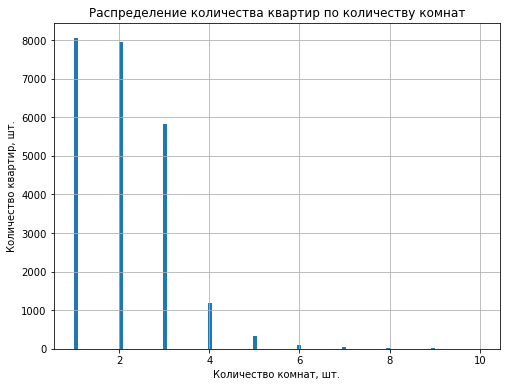

In [37]:
df.hist('rooms', bins=100, range=(1, 10), figsize=(8, 6))
plt.title('Распределение количества квартир по количеству комнат')
plt.xlabel('Количество комнат, шт.')
plt.ylabel('Количество квартир, шт.')

Количество квартир, в которых больше 6 комнат, стремится к нулю. Избавимся от них.

In [38]:
df = df.drop(df[df['rooms']>6].index)
df = df.reset_index(drop=True)

#### Высота потолка

Также видно, что минимальное значение высоты потолка — 1 метр, а это неправдаподобно мало. Посмотрим на гистограмму распределния высот потолка, чтобы определить границу нормальных значений.

Text(0, 0.5, 'Количество квартир, шт.')

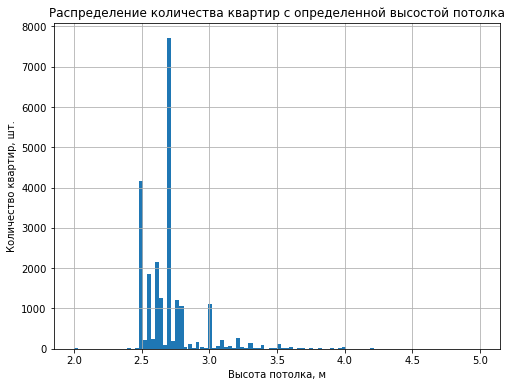

In [39]:
df.hist('ceiling_height', bins=100, range=(2,5), figsize=(8, 6))
plt.title('Распределение количества квартир с определенной высостой потолка')
plt.xlabel('Высота потолка, м')
plt.ylabel('Количество квартир, шт.')

Избавимся от квартир, в которых потолок меньше 2,5 метров и больше 4.

In [40]:
df = df.drop(df[(df['ceiling_height']<2.5) & (df['ceiling_height']>4)].index)
df = df.reset_index(drop=True)

#### Этаж

Построим гистограмму распределение количества квартир по этажам.

Text(0, 0.5, 'Количество квартир, шт.')

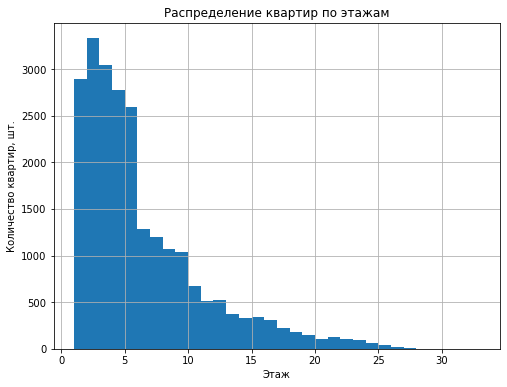

In [41]:
df.hist('floor', bins=32, range=(1,33), figsize=(8, 6))
plt.title('Распределение квартир по этажам')
plt.xlabel('Этаж')
plt.ylabel('Количество квартир, шт.')

Избавимся от квартир выше 25 этажа.

In [42]:
df = df.drop(df[df['floor']>25].index)
df = df.reset_index(drop=True)

Перейдем к более тяжелым для анализа столбцам.

**Цена**

Посмотрим на гистограмму.

Text(0, 0.5, 'Количество квартир, шт.')

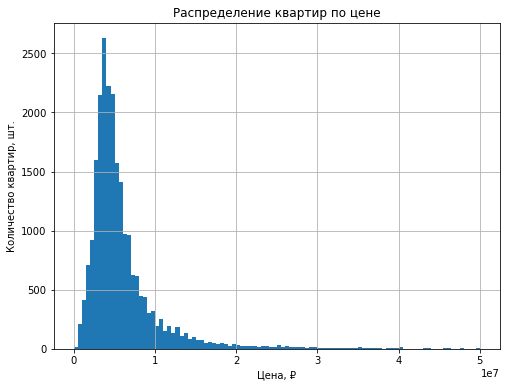

In [43]:
df.hist('last_price', bins=100, range=(0, 50000000), figsize=(8, 6))
plt.title('Распределение квартир по цене')
plt.xlabel('Цена, ₽')
plt.ylabel('Количество квартир, шт.')

Видно, что квартиры дороже 20 миллионов — редкость, поэтому избавимся от них.

In [44]:
df = df.drop(df[df['last_price']>20000000].index)
df = df.reset_index(drop=True)

Посмотрим на начало гистограммы поближе, чтобы опеределить анамально низкие цены.

Text(0, 0.5, 'Количество квартир, шт.')

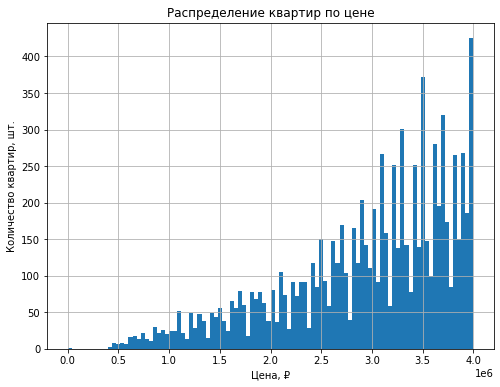

In [45]:
df.hist('last_price', bins=100, range=(0, 4000000), figsize=(8, 6))
plt.title('Распределение квартир по цене')
plt.xlabel('Цена, ₽')
plt.ylabel('Количество квартир, шт.')

Избавимся от квартир дешевле 750 тысяч рублей.

In [46]:
df = df.drop(df[df['last_price']<750000].index)
df = df.reset_index(drop=True)

#### Площадь

Снова построим гистограмму.

Text(0, 0.5, 'Количество квартир, шт.')

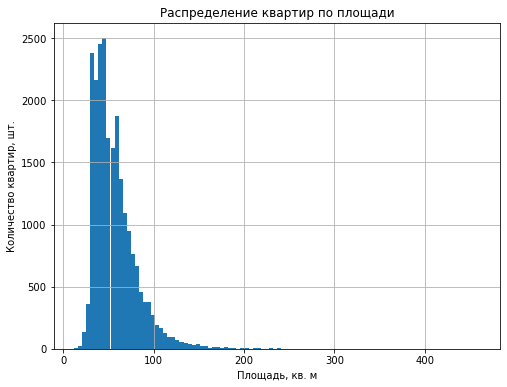

In [47]:
df.hist('total_area', bins=100, figsize=(8, 6))
plt.title('Распределение квартир по площади')
plt.xlabel('Площадь, кв. м')
plt.ylabel('Количество квартир, шт.')

Избавимся от квартир с площадью больше 150 квадратных метров.

In [48]:
df = df.drop(df[df['total_area']>150].index)
df = df.reset_index(drop=True)

Теперь посмотрим на начало гистограммы, чтобы найти маленькие квартиры.

Text(0, 0.5, 'Количество квартир, шт.')

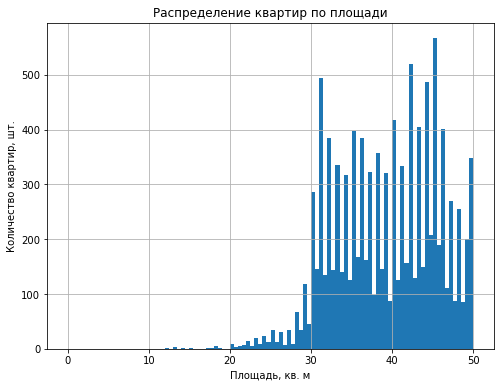

In [49]:
df.hist('total_area', bins=100, range=(0, 50), figsize=(8, 6))
plt.title('Распределение квартир по площади')
plt.xlabel('Площадь, кв. м')
plt.ylabel('Количество квартир, шт.')

Избавимся от квартир площадью меньше 25 квадратных метров.

In [50]:
df = df.drop(df[df['total_area']<25].index)
df = df.reset_index(drop=True)

Остался последний параметр — удаленность от центра. Мы не будем убирать маленькие значения, потому что квартиры вполне могут находиться в центре города. А вот на большие посмотрим.

Text(0, 0.5, 'Количество квартир, шт.')

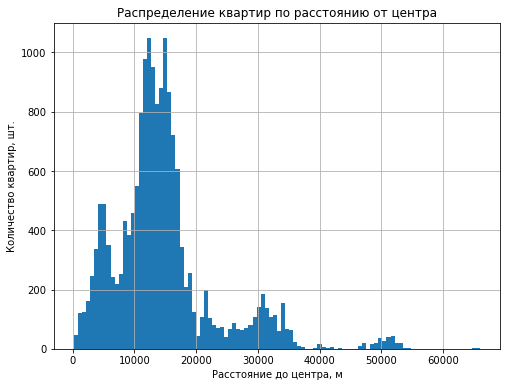

In [51]:
df.hist('cityCenters_nearest', bins=100, figsize=(8, 6))
plt.title('Распределение квартир по расстоянию от центра')
plt.xlabel('Расстояние до центра, м')
plt.ylabel('Количество квартир, шт.')

Около 50 километров наблюдается неожиданное увеличение предложения. Посмотрим, какие населенные пункты находятся в этом районе 50. 

In [52]:
df[(df['cityCenters_nearest']>45000) & (df['cityCenters_nearest']<53000)]['locality_name'].unique()

array(['Ломоносов', 'Кронштадт', 'Петергоф', 'Зеленогорск', 'Репино'],
      dtype=object)

Петергоф и Кронштадт — довольно большие города, к тому же популярные у туристов. Поэтому такой мини-пик не кажется странным. Уберем только те квартиры, которые находятся дальше 53 километров.

In [53]:
df = df.drop(df[df['cityCenters_nearest']>53000].index)
df = df.reset_index(drop=True)

#### Вывод

После анализа нужных для исследования столбцов мы избавились от редких и выбивающихся значений. Вот какими получились параметры «нормальных» квартир:

- от 1 до 6 комнат,
- потолки не ниже 2,5 и не выше 4 метров,
- этаж не выше 25,
- площадь от 25 до 150 квадратных метров.

### Факторы, влияющие на стоимость квартиры<a name="Факторы,-влияющие-на-стоимость-квартиры"></a>

Определим, какие факторы больше всего влияют на стоимость квартиры. В этом нам помогут матрица диаграмм рассеяния, матрица корреляции и диаграммы размаха для категорийных значений.

Проверим, как площадь, число комнат и удаленность от центра влияют на цену квартир. Для этого построим матрицу диаграмм рассеяния.

array([[<AxesSubplot:xlabel='last_price', ylabel='last_price'>,
        <AxesSubplot:xlabel='total_area', ylabel='last_price'>,
        <AxesSubplot:xlabel='rooms', ylabel='last_price'>,
        <AxesSubplot:xlabel='cityCenters_nearest', ylabel='last_price'>],
       [<AxesSubplot:xlabel='last_price', ylabel='total_area'>,
        <AxesSubplot:xlabel='total_area', ylabel='total_area'>,
        <AxesSubplot:xlabel='rooms', ylabel='total_area'>,
        <AxesSubplot:xlabel='cityCenters_nearest', ylabel='total_area'>],
       [<AxesSubplot:xlabel='last_price', ylabel='rooms'>,
        <AxesSubplot:xlabel='total_area', ylabel='rooms'>,
        <AxesSubplot:xlabel='rooms', ylabel='rooms'>,
        <AxesSubplot:xlabel='cityCenters_nearest', ylabel='rooms'>],
       [<AxesSubplot:xlabel='last_price', ylabel='cityCenters_nearest'>,
        <AxesSubplot:xlabel='total_area', ylabel='cityCenters_nearest'>,
        <AxesSubplot:xlabel='rooms', ylabel='cityCenters_nearest'>,
        <AxesSubplot:xl

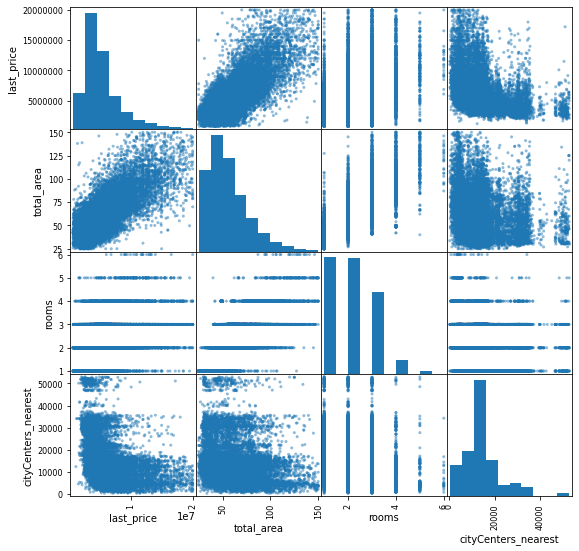

In [54]:
pd.plotting.scatter_matrix(df[['last_price', 'total_area', 'rooms', 'cityCenters_nearest']], figsize=(9, 9))

Удобнее всего исследовать зависимость по верхнему ряду.

Лучше всего прослеживается зависимость цены от площади. До 100 квадратных метров хорошо виден коридор значений, который похож на линейную зависимость. У квартир с площадью больше 100 метров зависимость менее четкая.

Зависимость от количества комнат не такая заметная, как от площади, но закономерности все же есть. Дорогих однокомнатных квартир меньше, чем двух-четырехкомнатных. Минимальные цены пяти- и шестикомнатных квартир выше, чем у одно-четырехкомнатных, но при этом максимальные меньше. Это довольно странно, потому что пяти- и шестикомнатные квартиры находятся ближе к центру (нижний ряд, третья диаграмма).

Зависимость от расстояния до центра есть, и она обратная. При расстоянии от центра больше 20 километров максимальная цена падает почти в два раза и продолжает уменьшаться, но несильно.

Посмотрим на коэффициенты корреляции.

In [55]:
print(df.loc[:, ['last_price', 'total_area', 'rooms', 'cityCenters_nearest']].corr())

                     last_price  total_area     rooms  cityCenters_nearest
last_price             1.000000    0.758420  0.468782            -0.365228
total_area             0.758420    1.000000  0.793454            -0.201879
rooms                  0.468782    0.793454  1.000000            -0.132680
cityCenters_nearest   -0.365228   -0.201879 -0.132680             1.000000


Они подтвержают сделанные выше выводы. Абсолютные значения коэффициентов зависимости цены от количества комнаты и расстояния до центра меньше, потому что эти зависимости имеют более сложный характер.

#### Зависимость цены от этажа

Посмотрим, как зависит цена от того, на каком этаже расположена квартира: первом, последнем или другом. Для этого воспользуемся диаграммами размаха, так как категория этажа — категорийный параметр.

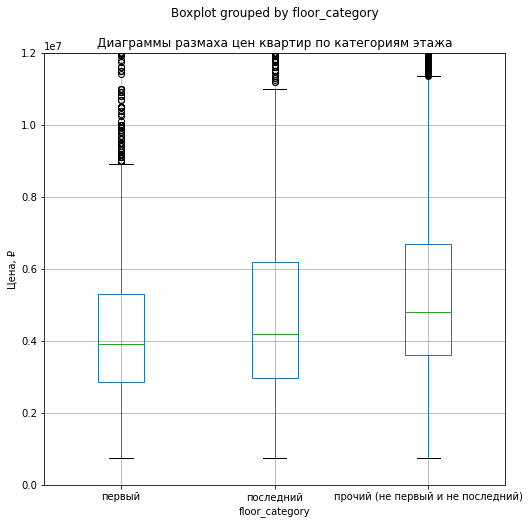

In [56]:
df.boxplot(by='floor_category', column='last_price', figsize=(8, 8))
plt.ylim(0, 12000000)
plt.title('Диаграммы размаха цен квартир по категориям этажа')
plt.ylabel('Цена, ₽')
floor_category = plt.gcf()

In [57]:
df.groupby('floor_category')['floor_category'].count()

floor_category
первый                                2777
последний                             3073
прочий (не первый и не последний)    16463
Name: floor_category, dtype: int64

Самые дешевые квартиры находятся на первом этаже, а дорогие — ни на первом, ни на последнем. Диаграммы размаха категорий «прочий» и «последний» находятся примерно на одном уровне, поэтому можно сказать, что стоимость квартиры несильно зависит от этажа, за исключением первого.

#### Зависимость цены от времени размещения

Посмотрим, как цена зависит от дня недели, месяца и года размещения публикации.

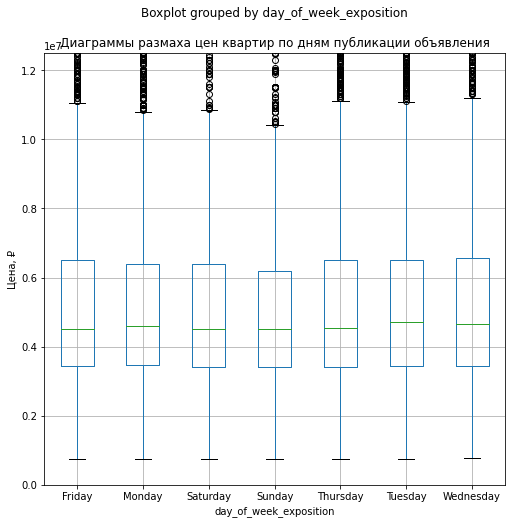

In [58]:
df.boxplot(by='day_of_week_exposition', column='last_price', figsize=(8, 8))
plt.ylim(0, 12500000)
plt.title('Диаграммы размаха цен квартир по дням публикации объявления')
plt.ylabel('Цена, ₽')
day_of_week_exposition = plt.gcf()

In [59]:
df.groupby('day_of_week_exposition')['day_of_week_exposition'].count()

day_of_week_exposition
Friday       3771
Monday       3410
Saturday     1835
Sunday       1603
Thursday     4005
Tuesday      3953
Wednesday    3736
Name: day_of_week_exposition, dtype: int64

Зависимость цены от того, в какой день было выложено объявление, если и есть, то на уровне погрешности. Видно, что в воскресенье цены чуть ниже. Хотя, возможно, это связано с тем, что в выходные выкладывают меньше объявлений.

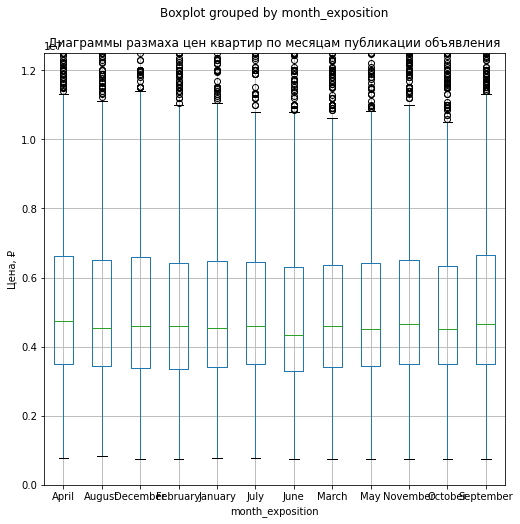

In [60]:
df.boxplot(by='month_exposition', column='last_price', figsize=(8, 8))
plt.ylim(0, 12500000)
plt.title('Диаграммы размаха цен квартир по месяцам публикации объявления')
plt.ylabel('Цена, ₽')
month_exposition = plt.gcf()

In [61]:
df.groupby('month_exposition')['month_exposition'].count()

month_exposition
April        2260
August       1639
December     1537
February     2484
January      1400
July         1569
June         1661
March        2452
May          1196
November     2219
October      2029
September    1867
Name: month_exposition, dtype: int64

С зависимостью цены от месяца публикации объявления такая же картина, как с днем недели — корреляции почти нет. В апреле и сентябре цены чуть выше, чем в другие месяцы, а в июне ниже.

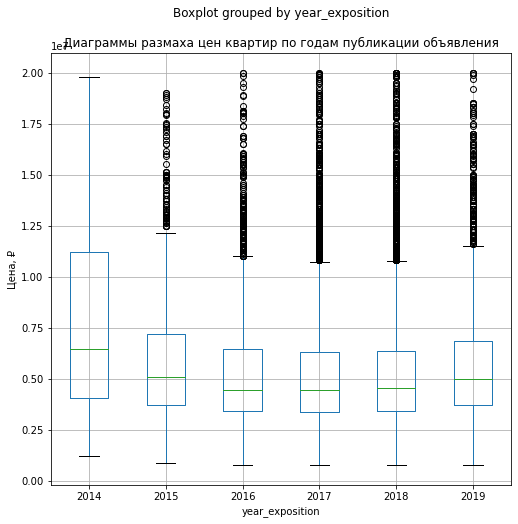

In [62]:
df.boxplot(by='year_exposition', column='last_price', figsize=(8, 8))
plt.title('Диаграммы размаха цен квартир по годам публикации объявления')
plt.ylabel('Цена, ₽')
year_exposition = plt.gcf()

In [63]:
df.groupby('year_exposition')['year_exposition'].count()

year_exposition
2014     114
2015    1090
2016    2615
2017    7691
2018    8086
2019    2717
Name: year_exposition, dtype: int64

Диаграммы размаха показывают, что самые дорогие квартиры продавали в 2014 году. Но в тому году было всего 114 объявлений, это в десятки раз меньше, чем в последующие годы. Поэтому будет считать этот столбец непрезентативным. Тогда получается, что цена квартир не зависит от года продажи.

### Исследование 10 населённых пунктов с наибольшим числом объявлений<a name="Исследование-10-населённых-пунктов-с-наибольшим-числом-объявлений"></a>

Для этого исследования создадим новый датафрейм и сохраним в нем информацию о нужных населенных пунктах.

In [64]:
list_of_top_10_lclts_by_ads_num = df.groupby('locality_name').count().sort_values(by='last_price', ascending=False).head(10).index.tolist()
top_10_lclts_by_ads_num = df[df['locality_name'].isin(list_of_top_10_lclts_by_ads_num)]
top_10_lclts_by_ads_num.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_per_meter,day_of_week_exposition,month_exposition,year_exposition,floor_category,living_to_total_area_ratio,kitchen_to_total_area_ratio
0,20,13000000,108.00000,2019-03-07,3,2.699219,16.0,51.000000,8,True,False,False,25.000000,<NA>,Санкт-Петербург,18863,16028.0,1,482,2,755,<NA>,120370,Thursday,March,2019,прочий (не первый и не последний),0.472168,0.231445
1,7,3350000,40.40625,2018-12-04,1,2.630859,11.0,18.593750,1,True,False,False,11.000000,2,Шушары,12817,18603.0,0,<NA>,0,<NA>,81,82908,Tuesday,December,2018,первый,0.460205,0.272217
2,10,5196000,56.00000,2015-08-20,2,2.699219,5.0,34.312500,4,True,False,False,8.296875,0,Санкт-Петербург,21741,13933.0,1,90,2,574,558,92786,Thursday,August,2015,прочий (не первый и не последний),0.612793,0.148193
3,2,10000000,100.00000,2018-06-19,2,3.029297,14.0,32.000000,13,True,False,False,41.000000,<NA>,Санкт-Петербург,31856,8098.0,2,112,1,48,121,100000,Tuesday,June,2018,прочий (не первый и не последний),0.320068,0.409912
5,6,3700000,37.31250,2017-11-02,1,2.640625,26.0,10.601562,6,True,False,False,14.398438,1,Парголово,52996,19143.0,0,<NA>,0,<NA>,155,99162,Thursday,November,2017,прочий (не первый и не последний),0.284180,0.385986


Построим сводную таблицу, чтобы посчитать среднюю цену квадратного метра и определить населенные пункты с самыми высокими и низками ценами на квартиры.

In [65]:
avg_price_per_meter_in_top_10_lclts = top_10_lclts_by_ads_num.pivot_table(index='locality_name', values='price_per_meter', aggfunc=['mean', 'count'])
avg_price_per_meter_in_top_10_lclts.columns = ['price_per_meter', 'count']
avg_price_per_meter_in_top_10_lclts.sort_values(by='price_per_meter', ascending=False)

,price_per_meter,count
locality_name,,
Санкт-Петербург,108722.330494,14675
Пушкин,101810.718310,355
Кудрово,94873.159817,438
Парголово,90249.077922,308
Мурино,85213.794007,534
Шушары,78216.217090,433
Колпино,75239.541667,336
Гатчина,68746.267101,307
Всеволожск,67265.204134,387


Самое дорогое жилье *предсказуемо* в Санкт-Петербурге: в среднем квадратный метр обойдется почти в 110 тысяч рублей. Самое дешевое — в Выборге, там квадратный метр стоит чуть больше 58 тысяч.

### Определение центральной зоны Санкт-Петербурга<a name="Определение-центральной-зоны-Санкт-Петербурга"></a>

Для того чтобы понять, какие квартиры входят в центр города, построим график зависимости цены квартиры от ее расстояния до центра. Но перед этим переведем расстояния до центра в километры и округлим до целых значений&

Text(0, 0.5, 'Цена, ₽')

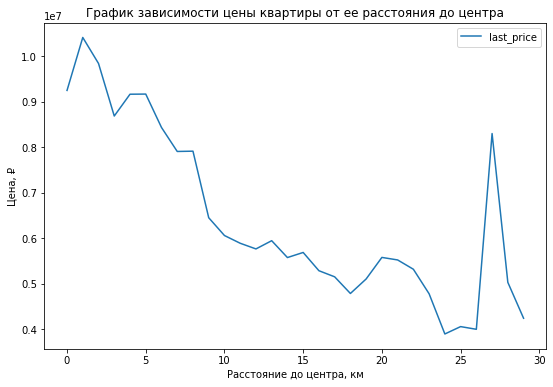

In [66]:
df['cityCenters_nearest_km'] = round(df['cityCenters_nearest'] / 1000)

spb_ads = df[df['locality_name']=='Санкт-Петербург']

spb_ads_pivot_table = spb_ads.pivot_table(index='cityCenters_nearest_km', values='last_price', aggfunc='mean')

spb_ads_pivot_table.plot(figsize=(9, 6))
plt.title('График зависимости цены квартиры от ее расстояния до центра')
plt.xlabel('Расстояние до центра, км')
plt.ylabel('Цена, ₽')

На графике видно, что резкое падение цен начинается с 5 километров. Значит центральная зона — это местность в радиусе 5 километров от центра.

### Сравнение квартир в центре Санкт-Петербурга с остальным городом<a name="Сравнение-квартир-в-центре-Санкт-Петербурга-с-остальным-городом"></a>

Построим гистограммы для следующих параметров: площадь, цена, число комнат — и сравним их с аналогичными для оставшейся части города.

Чтобы было удобнее работать с данными, сохраним информацию о квартирах в центре и в остальном городе в разные таблицы.

In [67]:
center_ads = spb_ads[spb_ads['cityCenters_nearest_km'] <= 5]
not_center_ads = spb_ads[spb_ads['cityCenters_nearest_km'] > 5]

Также напишем функцию, с помощью которой будем строить распределения. В центре города квартир гораздо меньше, чем во всем Санкт-Петербурге. Из-за этого если строить два распределения на одном графике, столбцы центральных квартир получатся очень низкими и не информативными. Поэтому придется строить распределения рядом.

In [68]:
def comparison_hists(dfs, parameter, n_bins, xlabel=''):
    fig, (ax1_areas, ax2_areas) = plt.subplots(1, 2, figsize=(14, 5))

    dfs[0].hist(parameter, bins=n_bins, ax=ax1_areas)
    ax1_areas.set_title('Распределение квартир по '+parameter+' \n(центр Санкт-Петербурга)')

    dfs[1].hist(parameter, bins=n_bins, ax=ax2_areas)
    ax2_areas.set_title('Распределение квартир по '+parameter+'\n(Санкт-Петербург, не включая центр)')

    for ax in [ax1_areas, ax2_areas]:
        ax.set(xlabel=xlabel, ylabel='Количество квартир, шт.')
    
    res = plt.gcf()
    plt.close()
    return res

#### Сравнение площадей

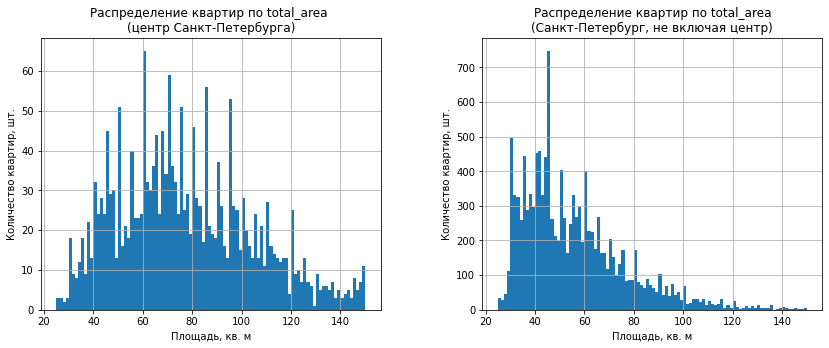

In [69]:
comparison_hists([center_ads, not_center_ads], 'total_area', 100, 'Площадь, кв. м')

На гистограммах выделяются много пиков. Видно, что они находятся на кратных пяти значениях: видимо, продавцы не стали писать точную площадь и округлили числа.

В центре квартиры больше, чем в остальном Санкт-Петербурге: пик наблюдается в районе 70 квадратых метров, в то время как во всем Питере в районе 45. Также в центре более плавное распределение, то есть квартир всех площадей примерно одинаковое количество, нет резкого спада после пика, как во всем городе.

#### Сравнение цен

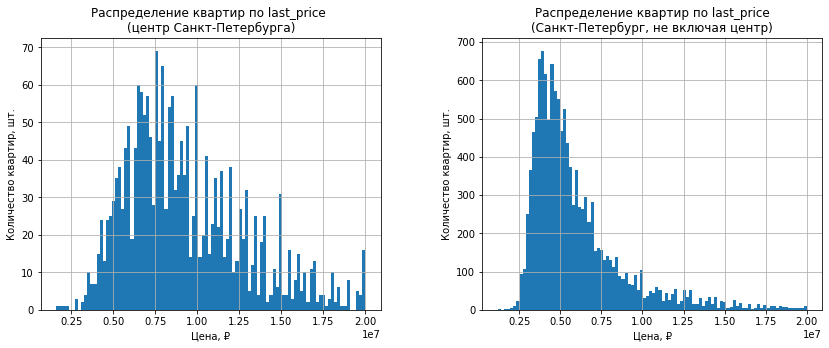

In [70]:
comparison_hists([center_ads, not_center_ads], 'last_price', 100, 'Цена, ₽')

Квартиры в центре Санкт-Петербурга ожидаемо стоят дороже, чем во всем городе. Это особенно заметно по хвостам распределений: если в гистограмме по всему городу квартир дороже 10 миллилионов рублей почти нет по сравнению с самыми популярными за 3–5 миллионов, то в центре города падение не такое резкое. Также пик в центре города смещен почти в два раза, в район 7,5 миллионов рублей.

#### Сравнение количества комнат

Следующая остановка — гистограммы по количеству комнат.

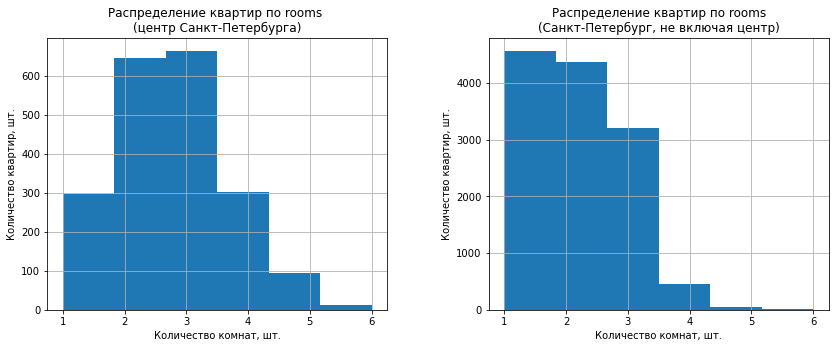

In [71]:
comparison_hists([center_ads, not_center_ads], 'rooms', 6, 'Количество комнат, шт.')

В центральном районе преобладают двух-трехкомнатные квартиры, в том время как во всем городе — одно-двухкомнатные. Также в центре гораздо больше квартир с четырьмя-пятью комнатами: четверокомнатных квартир столько же, сколько и однакомнатных. Во всем же гороже четырехкомнатных квартир в пять раз меньше, чем однакомнатных.

#### Матрицы диаграмм рассеяния для квартир в центре Санкт-Петербурга и в остальном городе

Построим матрицу диаграмм рассеяния, чтобы определить, как количество комнат, этаж и удаленность от центра влияют на цену квартир.

array([[<AxesSubplot:xlabel='last_price', ylabel='last_price'>,
        <AxesSubplot:xlabel='rooms', ylabel='last_price'>,
        <AxesSubplot:xlabel='floor', ylabel='last_price'>,
        <AxesSubplot:xlabel='cityCenters_nearest', ylabel='last_price'>],
       [<AxesSubplot:xlabel='last_price', ylabel='rooms'>,
        <AxesSubplot:xlabel='rooms', ylabel='rooms'>,
        <AxesSubplot:xlabel='floor', ylabel='rooms'>,
        <AxesSubplot:xlabel='cityCenters_nearest', ylabel='rooms'>],
       [<AxesSubplot:xlabel='last_price', ylabel='floor'>,
        <AxesSubplot:xlabel='rooms', ylabel='floor'>,
        <AxesSubplot:xlabel='floor', ylabel='floor'>,
        <AxesSubplot:xlabel='cityCenters_nearest', ylabel='floor'>],
       [<AxesSubplot:xlabel='last_price', ylabel='cityCenters_nearest'>,
        <AxesSubplot:xlabel='rooms', ylabel='cityCenters_nearest'>,
        <AxesSubplot:xlabel='floor', ylabel='cityCenters_nearest'>,
        <AxesSubplot:xlabel='cityCenters_nearest', ylabel='city

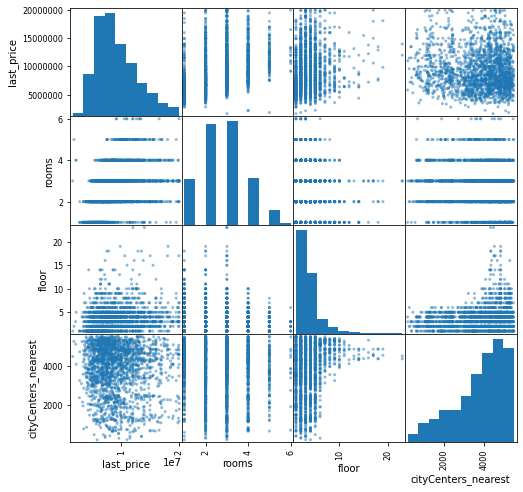

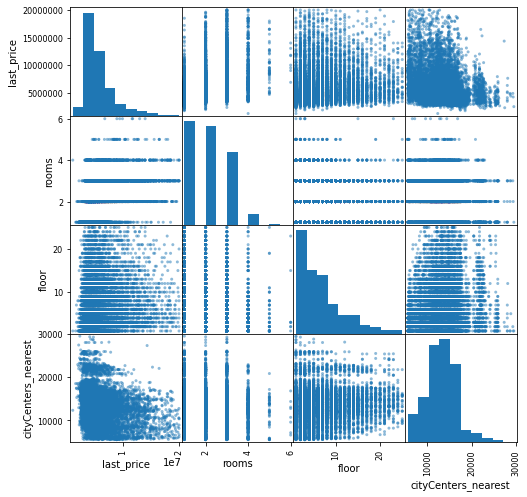

In [72]:
pd.plotting.scatter_matrix(center_ads[['last_price','rooms', 'floor', 'cityCenters_nearest']], figsize=(8, 8))
pd.plotting.scatter_matrix(not_center_ads[['last_price','rooms', 'floor', 'cityCenters_nearest']], figsize=(8, 8))

В центре цена квартиры зависит от количества комнат чуть сильнее, чем во всем городе. Это видно по минимальным ценам.

Зависимость цены от этажа в обоих случаях похожа: самые дешевые квартиры на первом этаже, а дорогие на втором и третьм. Дальше идет спад. При этом в центре города почти нет квартир выше 10 этажа, поэтому лучше не ориентироваься на данные о них.

Цена на квартиры в центре города не зависит от расстояния до центра, а во всем городе корреляция есть: чем ближе квартиры к центру, тем они дороже.

#### Вывод

Квартиры в центре дороже и больше по площади и количеству комнат, чем в целом в Санкт-Петербурге.

В центре города цена сильнее зависит от количества комнат и этажа, чем во всем Санкт-Петербурге. При этом в центральном районе расстояние до центра почти не влияет на цену квартиры, а во всем городе зависимость есть: чем ближе к центру находится квартира, тем она дороже. 

[К содержанию](#Содержание)

## 5. Общий вывод<a name="5.-Общий-вывод"></a>

В начале исследования мы обнаружили, что нам достались сырые данные: в них были пропуски и дубли. Мы заполнили и/или избавились от них, чтобы они не мешали работе.

Затем мы посмотрели, как квартиры распределены по площадям, по количеству комнат и по ценам. Вот, что получили:

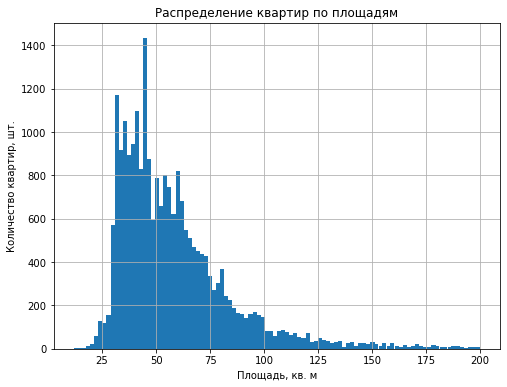

In [73]:
total_area_hist

Площадь средней квартиры — в районе 50 квадратных метров.

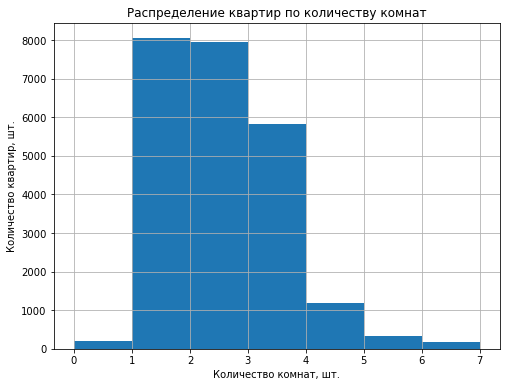

In [74]:
rooms_hist

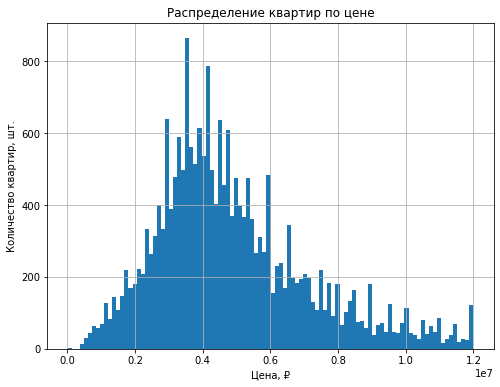

In [75]:
last_price_hist

«Средняя» квартира стоит от 3 до 5 миллионов рублей.

Также мы определили другие параметры «среднестатистических» квартир:

- от 1 до 6 комнат,
- потолки не ниже 2,5 и не выше 4 метров,
- этаж не выше 25,
- площадь от 25 до 150 квадратных метров.

Наконеце мы перешли к главному вопросу исследования — определению параметров, от которых зависит цена квартиры. Анализ показал, что сильнее всего цена зависит от плошади: чем площадь больше, тем цена выше.

[Text(0.5, 0, 'Площадь, кв. м'), Text(0, 0.5, 'Цена, миллионы рублей')]

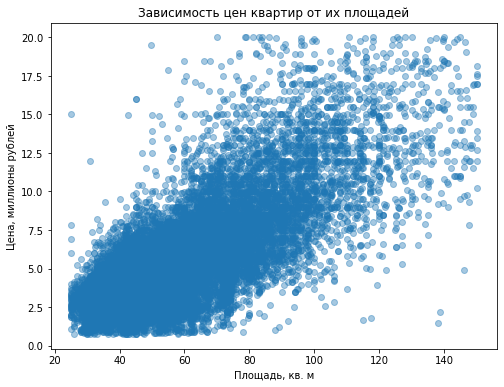

In [76]:
fig_price_area, ax_price_area = plt.subplots(figsize=(8, 6))
ax_price_area.scatter(df['total_area'], df['last_price'] / 10**6, alpha=0.4)
ax_price_area.set_title('Зависимость цен квартир от их площадей')
ax_price_area.set(xlabel='Площадь, кв. м', ylabel='Цена, миллионы рублей')

На втором месте количество комнат: здесь зависимость тоже прямая. И это неудивительно, потому что площадь квартиры сильно коррелирует с количеством комнат.

Text(0, 0.5, 'Цена, ₽')

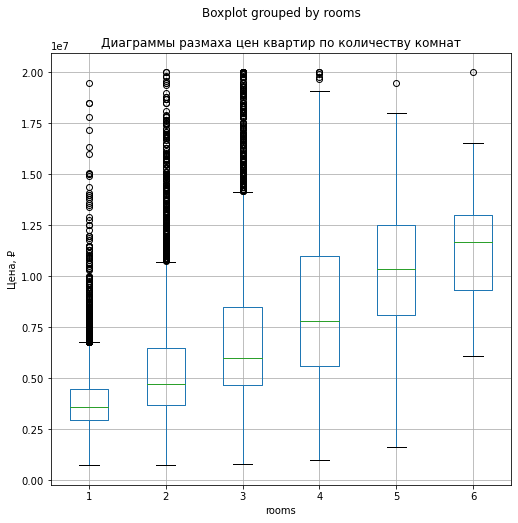

In [77]:
df.boxplot(by='rooms', column='last_price', figsize=(8, 8))
plt.title('Диаграммы размаха цен квартир по количеству комнат')
plt.ylabel('Цена, ₽')

На третьем месте удаленность от центра. В этом случае зависимость более сложная: до 20 километров от центра цены меняются несильно, а затем резко падают почти в два раза.

[Text(0.5, 0, 'Расстояние до центра, км'),
 Text(0, 0.5, 'Цена, миллионы рублей')]

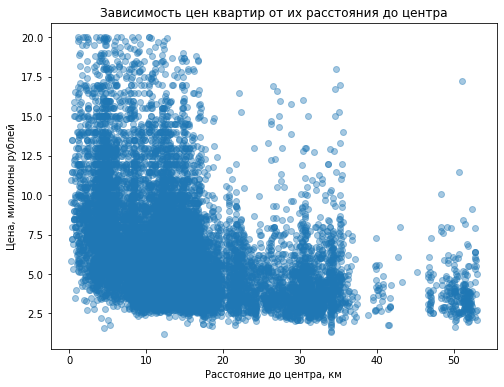

In [78]:
fig_price_dist, ax_price_dist = plt.subplots(figsize=(8, 6))
ax_price_dist.scatter(df['cityCenters_nearest'] / 10**3, df['last_price'] / 10**6, alpha=0.4)
ax_price_dist.set_title('Зависимость цен квартир от их расстояния до центра')
ax_price_dist.set(xlabel='Расстояние до центра, км', ylabel='Цена, миллионы рублей')

Также цена квартиры зависит от этажа: квартиры на первом этаже стоят дешевле, чем на остальных.

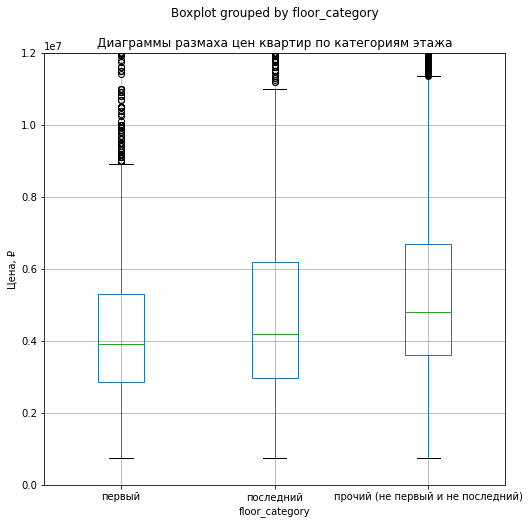

In [79]:
floor_category

А от даты размещения объявления цена не зависит. Об этом говорит то, что диаграммы размаха находятся примерно на одном уровне независимо от того, данные за какой период они отображают.

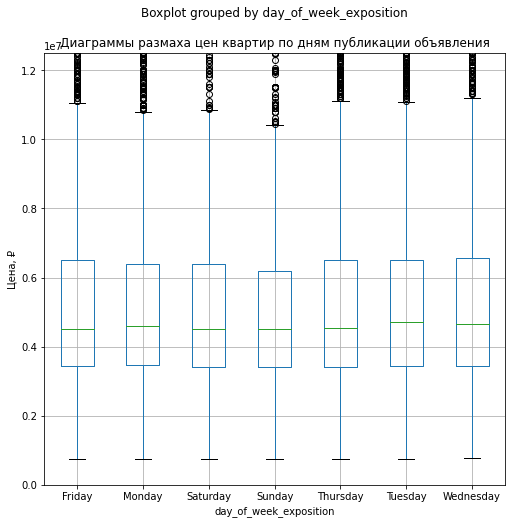

In [80]:
day_of_week_exposition

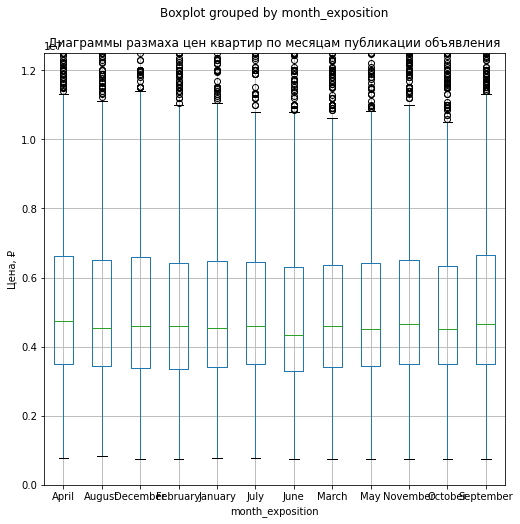

In [81]:
month_exposition

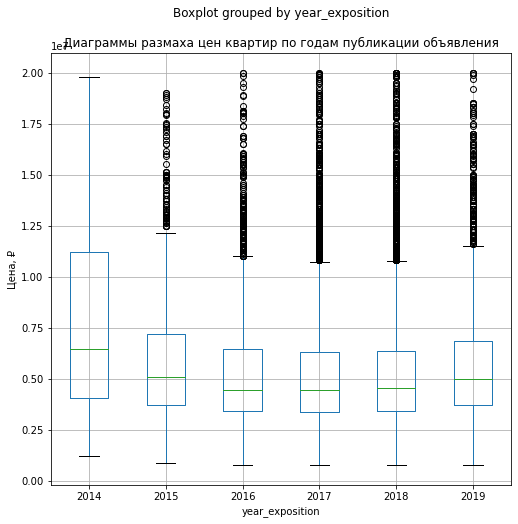

In [82]:
year_exposition

Диаграммы размаха показывают, что самые дорогие квартиры продавали в 2014 году. Но в тому году было всего 114 объявлений, это в десятки раз меньше, чем в последующие годы. Поэтому будет считать этот столбец непрезентативным.

In [83]:
df.groupby('year_exposition')['year_exposition'].count()

year_exposition
2014     114
2015    1090
2016    2615
2017    7691
2018    8086
2019    2717
Name: year_exposition, dtype: int64

[К содержанию](#Содержание)